In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, RationalQuadratic, DotProduct

plt.rcParams['font.size'] = 18

In [2]:
# Read in data file
df = pd.read_csv('runup_data.csv',parse_dates=True,index_col=0).dropna()
df.head()

,Hs,Tp,slope,runup
time,,,,
2014-05-20 10:00:00,0.538424,10.487102,0.162514,0.819012
2014-05-20 13:00:00,0.687159,9.593233,0.167000,0.882722
2014-05-20 14:00:00,0.655254,9.583498,0.166503,0.885877
2014-05-20 15:00:00,0.526552,10.487527,0.157757,0.854396
2014-05-20 16:00:00,0.543070,10.412249,0.160459,0.845645


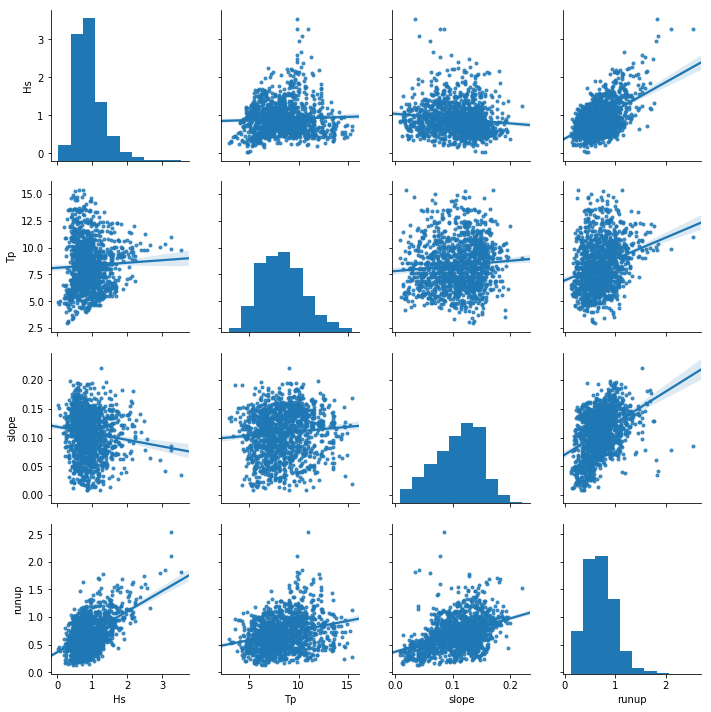

In [3]:
# Data exploration
# Change this two a 2d surface plot on the tril
sns.pairplot(df.sample(round(len(df)/6)),markers='.',kind='reg',size=2.5)

In [4]:
# Split data into training/testing
X = df.drop(columns='runup')
y = df[['runup']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=123)

In [5]:
# Scale training data and then test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
# Different Kernel Specification
kernel = RBF(1, (1e-2, 1e2))
# kernel = Matern(1, (1e-2, 1e2),1.5)
# kernel = DotProduct(1, (1e-2, 1e2))
# kernel = ExpSineSquared()
# kenrel = RationalQuadratic()

In [61]:
# Train GP model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1, normalize_y=True, random_state=123)
gp.fit(X_train_scaled, y_train)
y_pred, sigma = gp.predict(X_test_scaled, return_std=True)

In [62]:
# Evaluate Predictions
print('RMSE =', np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE = 0.19848273711320463


In [ ]:
# Consider different kernels and kenral combinations
# Consider GP with noise in the target variable

In [2]:
# GP 1D Example
def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [11]:
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = f(X).ravel()
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

kernel = RBF(80, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
y_pred, sigma = gp.predict(x, return_std=True)

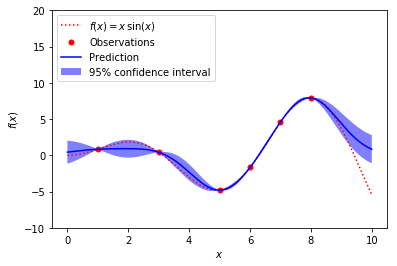

In [12]:
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')